In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from Spectral_Layer import Spectral

## Generate dataset

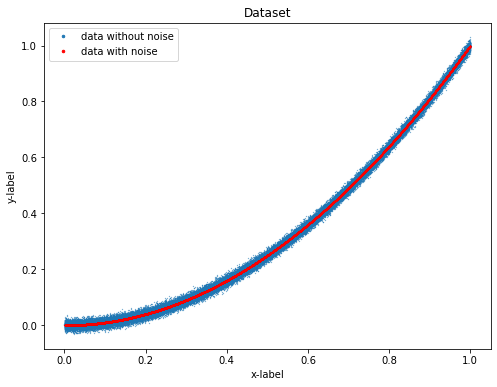

In [2]:
alpha = 2. 
sigma = 0.01
size = 70000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # noise
t = x**alpha
y = t + z   # add noise

X = []
Y = []
for i in range(size):
    X.append([x[i]])
    Y.append([y[i]])
    
X = np.array(X)
Y = np.array(Y)

plt.figure (figsize = (8, 6))
plt.plot(X, Y, marker='.', linestyle = '', label='data without noise', markersize=0.5)
plt.plot(x, t, marker='.', linestyle='', color='red', label='data with noise', markersize=0.5)
plt.title('Dataset')
plt.legend(markerscale=10.)
plt.xlabel('x-label')
plt.ylabel('y-label')
plt.show()

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Define dataset
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset, [50000, 10000, 10000])

# Define data loader
batch_size = 1500
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [4]:
# Spectral Regression model with a pruning method
config = {'base_grad' : False,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False}

class PruningRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 20, **config)
        self.spectral1 = Spectral(20, 20, **config)
        self.spectral2 = Spectral(20, 20, **config)
        self.spectralout = Spectral(20, 1, **config)
    
    def forward(self,x):
        out = self.spectralin(x)  # Imput: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectral2(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out
    
    def training_step(self, batch):
        x, y = batch 
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        x, y= batch 
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)   # Calculate loss
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}".format(epoch, result['val_loss']))
        
    # This method act directly on this class
    def pruning(self, 
                perc: float, 
                start_grad: bool = False, 
                end_grad: bool = False, 
                base_grad: bool = True):
        
        self.spectralin.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectral1.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectral2.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectralout.pruning_diag(perc, start_grad, end_grad, base_grad)
    
    # This method create new layers
    def pruning_new(self,
                    perc: float,
                    start_grad: bool = False, 
                    end_grad: bool = False, 
                    base_grad: bool = True):
        layer = []
        layer.append(self.spectralin.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        layer.append(self.spectral1.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        layer.append(self.spectral2.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        layer.append(self.spectralout.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        
        return layer
                   
        
        
pruning_model = PruningRegression()

In [5]:
config = {'start_grad' : False,
         'end_grad' : True,
         'base_grad' : True}

class PruningRegressionNew(PruningRegression):
    def __init__(self, perc):
        super(PruningRegression, self).__init__()
        layer = pruning_model.pruning_new(perc, **config)
        self.spectralin = layer[0]
        self.spectral1 = layer[1]
        self.spectral2 = layer[2]
        self.spectralout = layer[3]
        

In [6]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    #es = EarlyStopping(patience=5) # stop with patience 5
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Early stopping
        #if es.step(loss):
        #        break  

    return history

In [7]:
args = {'lr': 0.01,
       'model': pruning_model,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history = fit(20, **args)

Epoch [0], val_loss: 0.028704
Epoch [1], val_loss: 0.016546
Epoch [2], val_loss: 0.015727
Epoch [3], val_loss: 0.015181
Epoch [4], val_loss: 0.014663
Epoch [5], val_loss: 0.014259
Epoch [6], val_loss: 0.013854
Epoch [7], val_loss: 0.013522
Epoch [8], val_loss: 0.013236
Epoch [9], val_loss: 0.012913
Epoch [10], val_loss: 0.011488
Epoch [11], val_loss: 0.000684
Epoch [12], val_loss: 0.000508
Epoch [13], val_loss: 0.000427
Epoch [14], val_loss: 0.000406
Epoch [15], val_loss: 0.000389
Epoch [16], val_loss: 0.000368
Epoch [17], val_loss: 0.000357
Epoch [18], val_loss: 0.000340
Epoch [19], val_loss: 0.000325


In [8]:
args = {'start_grad': False,
       'end_grad': False,
       'base_grad': True,}

model1 = PruningRegressionNew(perc=25)


In [9]:
args = {'lr': 0.01,
       'model': model1,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history1 = fit(20, **args)

Epoch [0], val_loss: 0.000602
Epoch [1], val_loss: 0.000507
Epoch [2], val_loss: 0.000428
Epoch [3], val_loss: 0.000401
Epoch [4], val_loss: 0.000378
Epoch [5], val_loss: 0.000351
Epoch [6], val_loss: 0.000338
Epoch [7], val_loss: 0.000324
Epoch [8], val_loss: 0.000313
Epoch [9], val_loss: 0.000304
Epoch [10], val_loss: 0.000293
Epoch [11], val_loss: 0.000284
Epoch [12], val_loss: 0.000310
Epoch [13], val_loss: 0.000274
Epoch [14], val_loss: 0.000282
Epoch [15], val_loss: 0.000259
Epoch [16], val_loss: 0.000267
Epoch [17], val_loss: 0.000243
Epoch [18], val_loss: 0.000240
Epoch [19], val_loss: 0.000265


In [10]:
args = {'start_grad': False,
       'end_grad': False,
       'base_grad': True,}

model2 = PruningRegressionNew(perc=50)



In [11]:
args = {'lr': 0.01,
       'model': model2,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history2 = fit(20, **args)

Epoch [0], val_loss: 0.002356
Epoch [1], val_loss: 0.000548
Epoch [2], val_loss: 0.000460
Epoch [3], val_loss: 0.000407
Epoch [4], val_loss: 0.000370
Epoch [5], val_loss: 0.000355
Epoch [6], val_loss: 0.000343
Epoch [7], val_loss: 0.000329
Epoch [8], val_loss: 0.000331
Epoch [9], val_loss: 0.000308
Epoch [10], val_loss: 0.000295
Epoch [11], val_loss: 0.000294
Epoch [12], val_loss: 0.000278
Epoch [13], val_loss: 0.000277
Epoch [14], val_loss: 0.000261
Epoch [15], val_loss: 0.000257
Epoch [16], val_loss: 0.000256
Epoch [17], val_loss: 0.000263
Epoch [18], val_loss: 0.000265
Epoch [19], val_loss: 0.000237


In [12]:
args = {'start_grad': False,
       'end_grad': False,
       'base_grad': True,}

model3 = PruningRegressionNew(perc=75)



In [13]:
args = {'lr': 0.01,
       'model': model3,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history3 = fit(20, **args)

Epoch [0], val_loss: 0.016113
Epoch [1], val_loss: 0.012118
Epoch [2], val_loss: 0.006073
Epoch [3], val_loss: 0.000374
Epoch [4], val_loss: 0.000324
Epoch [5], val_loss: 0.000304
Epoch [6], val_loss: 0.000288
Epoch [7], val_loss: 0.000282
Epoch [8], val_loss: 0.000277
Epoch [9], val_loss: 0.000274
Epoch [10], val_loss: 0.000271
Epoch [11], val_loss: 0.000268
Epoch [12], val_loss: 0.000266
Epoch [13], val_loss: 0.000262
Epoch [14], val_loss: 0.000259
Epoch [15], val_loss: 0.000258
Epoch [16], val_loss: 0.000253
Epoch [17], val_loss: 0.000250
Epoch [18], val_loss: 0.000250
Epoch [19], val_loss: 0.000245


In [14]:
losses = [result['val_loss'] for result in history]
losses1 = [result['val_loss'] for result in history1]
losses2 = [result['val_loss'] for result in history2]
losses3 = [result['val_loss'] for result in history3]

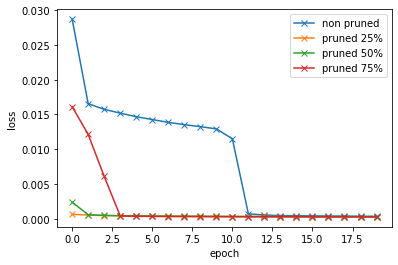

In [18]:
plt.plot(losses, '-x', label='non pruned')
plt.plot(losses1, '-x', label='pruned 25%')
plt.plot(losses2, '-x', label='pruned 50%')
plt.plot(losses3, '-x', label='pruned 75%')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

In [16]:
ris_non_pruned = evaluate(pruning_model, test_dl)
ris_pruned1 = evaluate(model1, test_dl)
ris_pruned2 = evaluate(model2, test_dl)
ris_pruned3 = evaluate(model3, test_dl)

print("Results obtained on the test dataset...")
print("Loss for non pruned model: {:.3} ".format(ris_non_pruned['val_loss']))
print("Loss for model pruned 25%: {:.3} ".format(ris_pruned1['val_loss']))
print("Loss for model pruned 50%: {:.3} ".format(ris_pruned2['val_loss']))
print("Loss for model pruned 75%: {:.3} ".format(ris_pruned3['val_loss']))


Results obtained on the test dataset...
Loss for non pruned model: 1.02 
Loss for model pruned 25%: 0.584 
Loss for model pruned 50%: 0.7 
Loss for model pruned 75%: 0.00024 
